In [76]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import datetime

import tensorflow as tf
import tfimm

import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy
from PIL import Image


In [117]:
def get_images_from_folder_to_dataframe(directory_path):
    all_files = os.listdir(directory_path)
    # image_files = [file for file in all_files if file.endswith(('jpg', 'jpeg', 'png'))]
    image_files = all_files
    full_paths = [os.path.join(directory_path, img_file) for img_file in image_files]
    df_images = pd.DataFrame(full_paths, columns=['image_path'])
    df_images["file_name"] = image_files
    return df_images,full_paths


def load_and_preprocess_image(image_path):
    # Read the image file
    raw = tf.io.read_file(image_path)
    # Decode the image file
    image = tf.image.decode_jpeg(raw, channels=3)
    # Resize the image to a fixed size (if necessary)
    image = tf.image.resize(image, [224, 224])
    # Normalize pixel values to be between 0 and 1
    image = image / 255.0
    image = tf.image.convert_image_dtype(image, dtype=tf.uint8, saturate=False)
    return image

def create_dataset(dataframe, image_paths):
    image_paths = list(dataframe["image_path"].values)
    labels = dataframe['PatientAge'].values #PatientAge

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda x, y: (load_and_preprocess_image(x), y))

    # dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    # dataset = dataset.map(lambda path: load_and_preprocess_image(path))
    return dataset

# Define the root directory of your dataset
images_dir = 'data\\ODIR5K\\preprocessed_images'
metadata_file_path = 'data\\ODIR5K\\full_df.xlsx'

metadata_file_path = 'train_test_split\\normal_left_train.csv'

df,image_paths = get_images_from_folder_to_dataframe(images_dir)
# df = df.merge(right=pd.read_excel(metadata_file_path),how='inner',left_on="file_name",right_on="filename")
df = df.merge(right=pd.read_csv(metadata_file_path),how='inner',left_on="file_name",right_on="Left-Fundus")

# df.drop(['filename', 'filepath'], axis=1, inplace=True) # filename is duplicate, using own image_path column
df.drop(['Left-Fundus'], axis=1, inplace=True)
df.columns = df.columns.str.replace(' ', '')
df.columns = df.columns.str.replace('-', '') 




# Create the dataset
dataset = create_dataset(df,image_paths)

In [118]:
df

,image_path,file_name,Unnamed:0,ID,PatientAge,PatientSex
0,data\ODIR5K\preprocessed_images\1034_left.jpg,1034_left.jpg,4082,1034,56,Male
1,data\ODIR5K\preprocessed_images\1034_left.jpg,1034_left.jpg,878,1034,56,Male
2,data\ODIR5K\preprocessed_images\1054_left.jpg,1054_left.jpg,4095,1054,59,Male
3,data\ODIR5K\preprocessed_images\1060_left.jpg,1060_left.jpg,895,1060,54,Male
4,data\ODIR5K\preprocessed_images\1060_left.jpg,1060_left.jpg,4099,1060,54,Male
...,...,...,...,...,...,...
1651,data\ODIR5K\preprocessed_images\84_left.jpg,84_left.jpg,3265,84,51,Female
1652,data\ODIR5K\preprocessed_images\8_left.jpg,8_left.jpg,3201,8,59,Male
1653,data\ODIR5K\preprocessed_images\939_left.jpg,939_left.jpg,809,939,41,Female
1654,data\ODIR5K\preprocessed_images\939_left.jpg,939_left.jpg,4013,939,41,Female


The first patient is 46 years old:


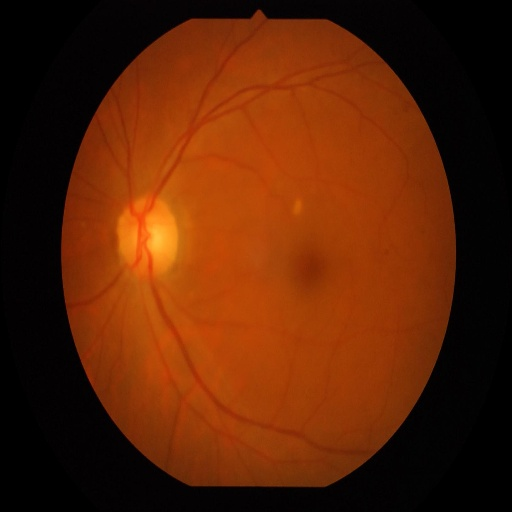

In [119]:
# Example usage: Load the first image in the DataFrame
idx=74
first_image_path = df.loc[idx, 'image_path']
print(f"The first patient is {df['PatientAge'][idx]} years old:")
Image.open(first_image_path)

In [120]:
for data in dataset.take(1):
    print(data)

(<tf.Tensor: shape=(224, 224, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=56>)


In [121]:
dataset

<MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [122]:
# Batch the dataset
batch_size = 1
dataset = dataset.batch(batch_size)

In [123]:
#split dataset
train_dataset = dataset.take(int(0.8 * len(dataset)))  # Take 80% of the data for training
validation_dataset = dataset.skip(int(0.8 * len(dataset)))

In [84]:
# val_batches = tf.data.experimental.cardinality(validation_dataset)

#take some data from validation set and put it into test set
# test_dataset = validation_dataset.take(val_batches // 5)
# validation_dataset = validation_dataset.skip(val_batches // 5)



In [124]:
metadata_file_path = 'train_test_split\\normal_left_test.csv'

test_df,test_image_paths = get_images_from_folder_to_dataframe(images_dir)
# test_df = test_df.merge(right=pd.read_excel(metadata_file_path),how='inner',left_on="file_name",right_on="filename")
test_df = test_df.merge(right=pd.read_csv(metadata_file_path),how='inner',left_on="file_name",right_on="Left-Fundus")

# test_df.drop(['filename', 'filepath'], axis=1, inplace=True) # filename is duplicate, using own image_path column
test_df.drop(['Left-Fundus'], axis=1, inplace=True)
test_df.columns = test_df.columns.str.replace(' ', '')
test_df.columns = test_df.columns.str.replace('-', '') 
# Create the test dataset
test_dataset = create_dataset(test_df,test_image_paths)

In [125]:
test_dataset

<MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [126]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [127]:
# Create the base model
model_name = "vit_large_patch16_224"
base_model = tfimm.create_model(
    model_name,
    nb_classes=0  # this removes the final layer
)

# Load base_model weights (by_name=True because nb_classes=0 removes a layer)
model_path = "RETFound_CFP_weights.h5" # get from RETFound github

base_model.load_weights(model_path, by_name=True, skip_mismatch=False)
base_model.trainable = False
# base_model.summary()

# Input layer
input_shape = (224, 224, 3)
inputs = tf.keras.Input(shape=input_shape)

# ViT layer
x = base_model(inputs)

# Add layers to match the original architecture leading up to the 'head' layer
# x = tf.keras.layers.LayerNormalization()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
prediction = tf.keras.layers.Dense(1, activation='relu',name='head')(x)


# Define the model
model = tf.keras.Model(inputs=inputs, outputs=prediction)
model.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vit_large_patch16_224 (ViT)  (None, 1024)             303301632 
                                                                 
 dense_3 (Dense)             (None, 512)               524800    
                                                                 
 head (Dense)                (None, 1)                 513       
                                                                 
Total params: 303,826,945
Trainable params: 525,313
Non-trainable params: 303,301,632
_________________________________________________________________


In [128]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanAbsoluteError(),
              metrics=['mean_absolute_error'])

In [49]:
%load_ext tensorboard
# launch from console with command: tensorboard --logdir=./

In [129]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[tensorboard_callback]
)

Epoch 1/10
1324/1324 [==============================] - 231s 157ms/step - loss: 11.2438 - mean_absolute_error: 11.2438 - val_loss: 8.8424 - val_mean_absolute_error: 8.8424
Epoch 2/10
1324/1324 [==============================] - 203s 153ms/step - loss: 9.5104 - mean_absolute_error: 9.5104 - val_loss: 8.3200 - val_mean_absolute_error: 8.3200
Epoch 3/10
1324/1324 [==============================] - 203s 153ms/step - loss: 9.5249 - mean_absolute_error: 9.5249 - val_loss: 8.6396 - val_mean_absolute_error: 8.6396
Epoch 4/10
1324/1324 [==============================] - 202s 152ms/step - loss: 9.5791 - mean_absolute_error: 9.5791 - val_loss: 8.9966 - val_mean_absolute_error: 8.9966
Epoch 5/10
1324/1324 [==============================] - 203s 153ms/step - loss: 9.2510 - mean_absolute_error: 9.2510 - val_loss: 8.6311 - val_mean_absolute_error: 8.6311
Epoch 6/10
1324/1324 [==============================] - 204s 153ms/step - loss: 9.1001 - mean_absolute_error: 9.1001 - val_loss: 8.6179 - val_mean_a

In [ ]:
model.save_weights('CFPmodel_'+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+'.h5')

In [132]:
test_dataset
batch_size = 1
test_dataset = test_dataset.batch(batch_size)

In [133]:
predictions = model.predict(test_dataset)
predictions

array([[59.20091 ],
       [58.322487],
       [59.045345],
       [56.81286 ],
       [56.81286 ],
       [59.891644],
       [59.054783],
       [61.015465],
       [59.914696],
       [56.87767 ],
       [63.488697],
       [54.264095],
       [57.196392],
       [56.00674 ],
       [59.064846],
       [59.24661 ],
       [59.645718],
       [54.820637],
       [56.303375],
       [59.21745 ],
       [62.01335 ],
       [58.5705  ],
       [60.60723 ],
       [60.620564],
       [57.225933],
       [57.225933],
       [60.003487],
       [59.90699 ],
       [57.097263],
       [57.052464],
       [58.94666 ],
       [57.102512],
       [57.612606],
       [59.68595 ],
       [51.071796],
       [59.479046],
       [58.250286],
       [58.507633],
       [58.868076],
       [56.80752 ],
       [46.647186],
       [55.93053 ],
       [57.16576 ],
       [55.950554],
       [55.10227 ],
       [60.669353],
       [60.669353],
       [57.59206 ],
       [59.721737],
       [56.312504],


In [134]:
y_true = []
for images, labels in test_dataset.take(6):
    y_true.append(tf.cast(labels, tf.int32))
    print(labels)

tf.Tensor([59], shape=(1,), dtype=int64)
tf.Tensor([32], shape=(1,), dtype=int64)
tf.Tensor([55], shape=(1,), dtype=int64)
tf.Tensor([44], shape=(1,), dtype=int64)
tf.Tensor([44], shape=(1,), dtype=int64)
tf.Tensor([61], shape=(1,), dtype=int64)


In [135]:
y_true[0].numpy() - predictions[0]

array([-0.20090866])

In [136]:
sumdiff=0
for i in range(len(y_true)):
    absdiff = np.abs(y_true[i].numpy() - predictions[i])
    sumdiff+=absdiff
mean_diff = sumdiff/(len(y_true))

In [137]:
mean_diff


array([9.55046908])